In [1]:
import scanpy as sc
import pandas as pd
import numpy as np
import seaborn as sns
import mudata as md
import networkx as nx
import matplotlib.pyplot as plt

import gc
import sys
sys.path.append('../')

from utils.gglasso_pipeline import gg_lasso_network_analysis
from gglasso.problem import glasso_problem
from utils.utils import calc_sparsity, plot_lambda1_path
from gglasso.helper.basic_linalg import scale_array_by_diagonal
from scipy.cluster.hierarchy import linkage
from latentcor import latentcor

import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

### PSA

In [2]:
psa_mudata = md.read("../data/preprocessed/psa_mudata_preprocessed.h5mu")
psa_mudata

c:\Users\Jan\.conda\envs\bacdrop\lib\site-packages\mudata\_core\mudata.py:491: UserWarning: Cannot join columns with the same name because var_names are intersecting.
  warnings.warn(


MuData object with n_obs × n_vars = 188 × 1489
  3 modalities
    all_genes:	188 x 1108
      obs:	'strains', 'n_genes_by_counts', 'total_counts', 'log1p_n_genes_by_counts', 'log1p_total_counts', 'total_counts_rRNA', 'log1p_total_counts_rRNA', 'pct_counts_rRNA', 'outlier', 'n_counts'
      var:	'strains', 'matchin_protein', 'protein', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'protein_name', 'rRNA', 'PC_lev0', 'PC_lev1', 'PC_lev2', 'PC_lev3', 'PC_lev4', 'PC_lev5', 'PC_lev6', 'log1p_mean_counts', 'log1p_total_counts', 'n_counts'
      uns:	'genes_match', 'protein_match', 'unmatch_genes'
      layers:	'log1p', 'norm_counts', 'raw_counts', 'sqrt_counts'
    gc1_genes:	188 x 353
      obs:	'strains', 'n_genes_by_counts', 'total_counts', 'log1p_n_genes_by_counts', 'log1p_total_counts', 'total_counts_rRNA', 'log1p_total_counts_rRNA', 'pct_counts_rRNA', 'outlier', 'n_counts'
      var:	'strains', 'matchin_protein', 'protein', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'protein_name', 'rRNA', 'PC_lev0', 'PC_lev1', 'PC_lev2', 'PC_lev3', 'PC_lev4', 'PC_lev5', 'PC_lev6', 'log1p_mean_counts', 'log1p_total_counts', 'n_counts'
      uns:	'genes_match', 'protein_match', 'unmatch_genes'
      layers:	'log1p', 'norm_counts', 'raw_counts', 'sqrt_counts'
    gc5_genes:	175 x 28
      obs:	'strains', 'n_genes_by_counts', 'total_counts', 'log1p_n_genes_by_counts', 'log1p_total_counts', 'total_counts_rRNA', 'log1p_total_counts_rRNA', 'pct_counts_rRNA', 'outlier', 'n_counts'
      var:	'strains', 'matchin_protein', 'protein', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'protein_name', 'rRNA', 'PC_lev0', 'PC_lev1', 'PC_lev2', 'PC_lev3', 'PC_lev4', 'PC_lev5', 'PC_lev6', 'log1p_mean_counts', 'log1p_total_counts', 'n_counts'
      uns:	'genes_match', 'protein_match', 'unmatch_genes'
      layers:	'log1p', 'norm_counts', 'raw_counts', 'sqrt_counts'

In [3]:
print("Sparsity:\t\t", calc_sparsity(psa_mudata["gc5_genes"].X.A))
print("Mean counts per gene:\t", np.mean(np.sum(psa_mudata["gc5_genes"].X.A, axis=1)))
print("Median counts per gene:\t", np.median(np.sum(psa_mudata["gc5_genes"].X.A, axis=1)))
print("Mean genes per cell: \t", np.mean(np.sum(psa_mudata["gc5_genes"].X.A, axis=0)))
print("Median genes per cell:\t", np.median(np.sum(psa_mudata["gc5_genes"].X.A, axis=0)))

Sparsity:		 0.8840816326530612
Mean counts per gene:	 3.5942857
Median counts per gene:	 3.0
Mean genes per cell: 	 22.464285
Median genes per cell:	 16.5


## Datasets

In [4]:
psa_mrna_gc5 = psa_mudata["gc5_genes"][:, ~psa_mudata["gc5_genes"].var["rRNA"]].copy()
psa_mrna_gc5

AnnData object with n_obs × n_vars = 175 × 19
    obs: 'strains', 'n_genes_by_counts', 'total_counts', 'log1p_n_genes_by_counts', 'log1p_total_counts', 'total_counts_rRNA', 'log1p_total_counts_rRNA', 'pct_counts_rRNA', 'outlier', 'n_counts'
    var: 'strains', 'matchin_protein', 'protein', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'protein_name', 'rRNA', 'PC_lev0', 'PC_lev1', 'PC_lev2', 'PC_lev3', 'PC_lev4', 'PC_lev5', 'PC_lev6', 'log1p_mean_counts', 'log1p_total_counts', 'n_counts'
    uns: 'genes_match', 'protein_match', 'unmatch_genes'
    layers: 'log1p', 'norm_counts', 'raw_counts', 'sqrt_counts'

In [5]:
psa_rrna_gc5 = psa_mudata["gc5_genes"][:, psa_mudata["gc5_genes"].var["rRNA"]].copy()
psa_rrna_gc5

AnnData object with n_obs × n_vars = 175 × 9
    obs: 'strains', 'n_genes_by_counts', 'total_counts', 'log1p_n_genes_by_counts', 'log1p_total_counts', 'total_counts_rRNA', 'log1p_total_counts_rRNA', 'pct_counts_rRNA', 'outlier', 'n_counts'
    var: 'strains', 'matchin_protein', 'protein', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'protein_name', 'rRNA', 'PC_lev0', 'PC_lev1', 'PC_lev2', 'PC_lev3', 'PC_lev4', 'PC_lev5', 'PC_lev6', 'log1p_mean_counts', 'log1p_total_counts', 'n_counts'
    uns: 'genes_match', 'protein_match', 'unmatch_genes'
    layers: 'log1p', 'norm_counts', 'raw_counts', 'sqrt_counts'

In [6]:
psa_mrna_gc1 = psa_mudata["gc1_genes"][:, ~psa_mudata["gc1_genes"].var["rRNA"]].copy()
psa_mrna_gc1

AnnData object with n_obs × n_vars = 188 × 314
    obs: 'strains', 'n_genes_by_counts', 'total_counts', 'log1p_n_genes_by_counts', 'log1p_total_counts', 'total_counts_rRNA', 'log1p_total_counts_rRNA', 'pct_counts_rRNA', 'outlier', 'n_counts'
    var: 'strains', 'matchin_protein', 'protein', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'protein_name', 'rRNA', 'PC_lev0', 'PC_lev1', 'PC_lev2', 'PC_lev3', 'PC_lev4', 'PC_lev5', 'PC_lev6', 'log1p_mean_counts', 'log1p_total_counts', 'n_counts'
    uns: 'genes_match', 'protein_match', 'unmatch_genes'
    layers: 'log1p', 'norm_counts', 'raw_counts', 'sqrt_counts'

In [7]:
psa_rrna_gc1 = psa_mudata["gc1_genes"][:, psa_mudata["gc1_genes"].var["rRNA"]].copy()
psa_rrna_gc1

AnnData object with n_obs × n_vars = 188 × 39
    obs: 'strains', 'n_genes_by_counts', 'total_counts', 'log1p_n_genes_by_counts', 'log1p_total_counts', 'total_counts_rRNA', 'log1p_total_counts_rRNA', 'pct_counts_rRNA', 'outlier', 'n_counts'
    var: 'strains', 'matchin_protein', 'protein', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'protein_name', 'rRNA', 'PC_lev0', 'PC_lev1', 'PC_lev2', 'PC_lev3', 'PC_lev4', 'PC_lev5', 'PC_lev6', 'log1p_mean_counts', 'log1p_total_counts', 'n_counts'
    uns: 'genes_match', 'protein_match', 'unmatch_genes'
    layers: 'log1p', 'norm_counts', 'raw_counts', 'sqrt_counts'

### GC5: latentcor + GGL

c:\Users\Jan\.conda\envs\bacdrop\lib\site-packages\statsmodels\stats\correlation_tools.py:90: IterationLimitWarning: 
Maximum iteration reached.

  warnings.warn(iteration_limit_doc, IterationLimitWarning)


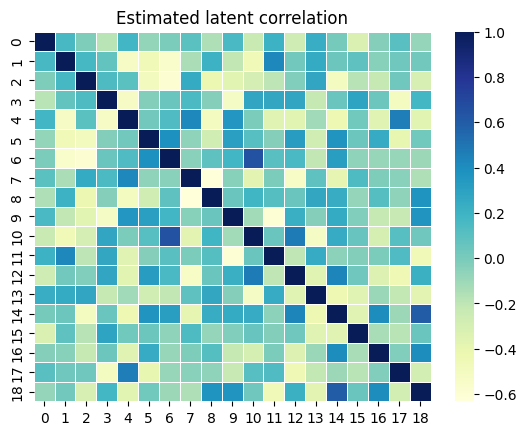

In [8]:
tps = ['tru' for i in range(psa_mrna_gc5.shape[1])]
psa_est_mrna_gc5 = latentcor(psa_mrna_gc5.layers['sqrt_counts'].A, tps=tps, method='approx', use_nearPD=True, nu=0.001, showplot=True)

In [9]:
np.save("../data/latent_est/4S/psa_est_gc5.npy", psa_est_mrna_gc5)

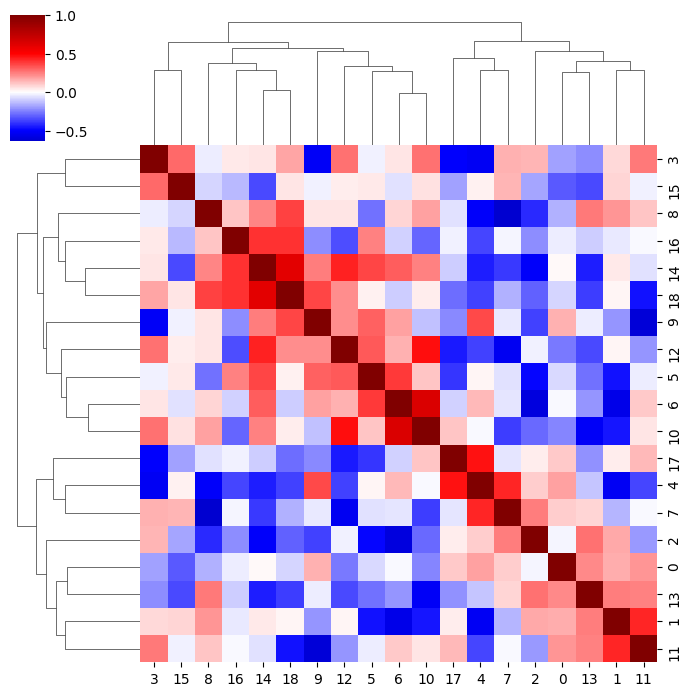

In [10]:
sns.clustermap(psa_est_mrna_gc5['R'], cmap='seismic', figsize=(7, 7), center=0)

In [11]:
psa_mrna_gc5_link = linkage(y=psa_est_mrna_gc5['R'], method="average", metric="euclidean")

In [12]:
psa_ggl_gc5 = gg_lasso_network_analysis(N=psa_mrna_gc5.shape[0], estimate=psa_est_mrna_gc5)
psa_ggl_gc5.create_problem(S_col="R", latent=False)
psa_ggl_gc5.model_selection(lambda1_range=np.logspace(0, -6, 200), gamma=0.1)

 
SINGLE GRAPHICAL LASSO PROBLEM 
Regularization parameters:
{'lambda1': 0.05, 'mu1': None}
ADMM terminated after 11 iterations with status: optimal.
ADMM terminated after 12 iterations with status: optimal.
ADMM terminated after 26 iterations with status: optimal.
ADMM terminated after 10 iterations with status: optimal.
ADMM terminated after 11 iterations with status: optimal.
ADMM terminated after 11 iterations with status: optimal.
ADMM terminated after 24 iterations with status: optimal.
ADMM terminated after 24 iterations with status: optimal.
ADMM terminated after 10 iterations with status: optimal.
ADMM terminated after 10 iterations with status: optimal.
ADMM terminated after 22 iterations with status: optimal.
ADMM terminated after 22 iterations with status: optimal.
ADMM terminated after 23 iterations with status: optimal.
ADMM terminated after 24 iterations with status: optimal.
ADMM terminated after 25 iterations with status: optimal.
ADMM terminated after 26 iterations wi

In [13]:
psa_sol_gc5 = psa_ggl_gc5.P.solution.precision_

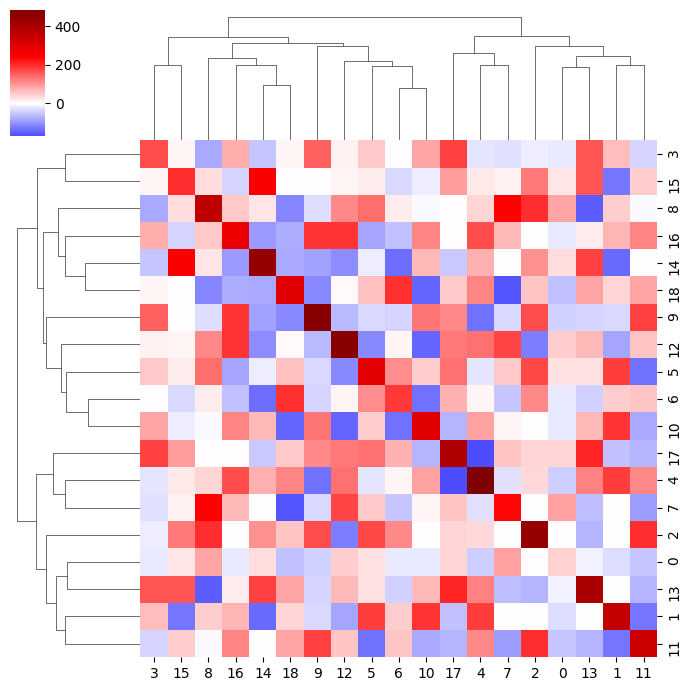

In [15]:
sns.clustermap(psa_sol_gc5, cmap="seismic", col_linkage=psa_mrna_gc5_link, row_linkage=psa_mrna_gc5_link, figsize=(7, 7), center=0)

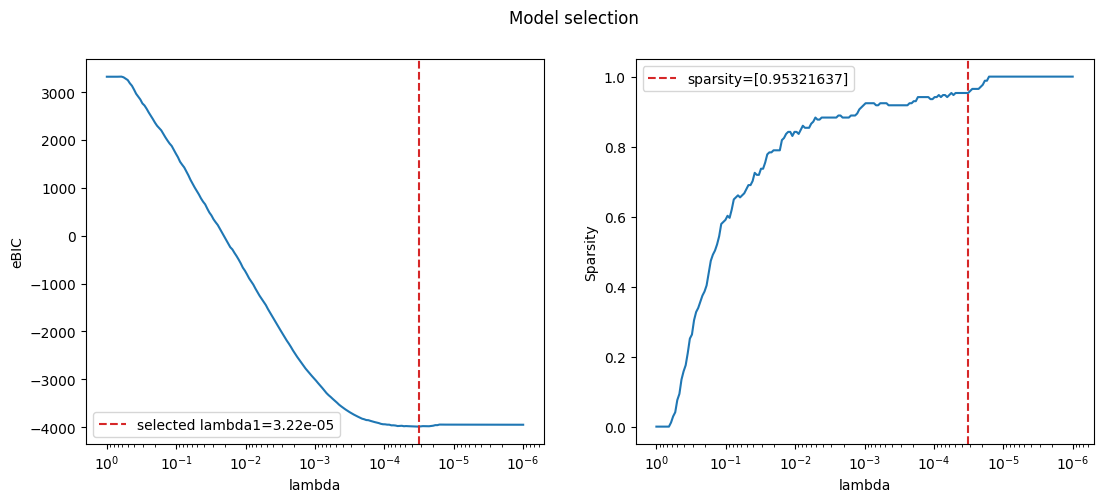

In [16]:
P_dict = psa_ggl_gc5.P.__dict__

lambda1 = P_dict["reg_params"]["lambda1"]
lambda1_range = P_dict["modelselect_params"]["lambda1_range"]
sparsity = P_dict["modelselect_stats"]["SP"]
eBIC = P_dict["modelselect_stats"]["BIC"][0.1]

fig, axs = plt.subplots(1, 2, figsize=(13, 5))

sns.lineplot(x=lambda1_range, y=eBIC.squeeze(), ax=axs[0])
axs[0].axvline(x=lambda1, ls="--", color="C3", label=f"selected lambda1={np.round(lambda1, 7)}")
axs[0].set_xscale("log")
axs[0].set_xlabel("lambda")
axs[0].set_ylabel("eBIC")
axs[0].invert_xaxis()
axs[0].legend()

sns.lineplot(x=lambda1_range, y=sparsity.squeeze(), ax=axs[1])
axs[1].axvline(x=lambda1, ls="--", color="C3", label=f"sparsity={sparsity[np.where(lambda1_range == lambda1)[0][0]]}")
axs[1].set_xscale("log")
axs[1].set_xlabel("lambda")
axs[1].set_ylabel("Sparsity")
axs[1].invert_xaxis()
axs[1].legend()
plt.suptitle("Model selection")
plt.show()

In [18]:
#number of nodes
print("nodes:", psa_sol_gc5.shape[0])
#number of edges
print("edges:", np.count_nonzero(np.triu(psa_sol_gc5, k=1)))
#ebic value
print(eBIC[np.where(lambda1_range == lambda1)[0][0]])

nodes: 19
edges: 163
[-3988.53847888]


### GC1: latentcor + GGL

c:\Users\Jan\.conda\envs\bacdrop\lib\site-packages\statsmodels\stats\correlation_tools.py:90: IterationLimitWarning: 
Maximum iteration reached.

  warnings.warn(iteration_limit_doc, IterationLimitWarning)


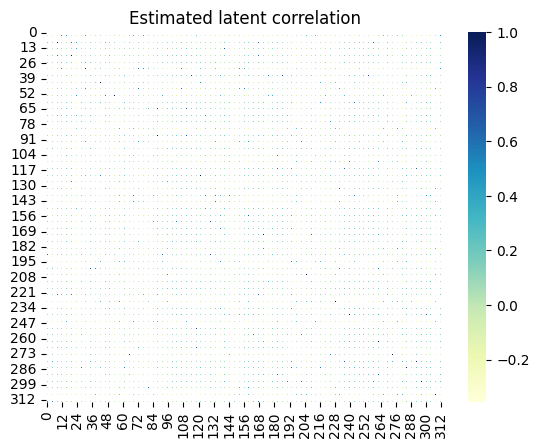

In [19]:
tps = ['tru' for i in range(psa_mrna_gc1.shape[1])]
psa_est_mrna_gc1 = latentcor(psa_mrna_gc1.layers['sqrt_counts'].A, tps=tps, method='approx', use_nearPD=True, nu=0.001, showplot=True)

In [20]:
np.save("../data/latent_est/4S/psa_est_gc1_.npy", psa_est_mrna_gc1)

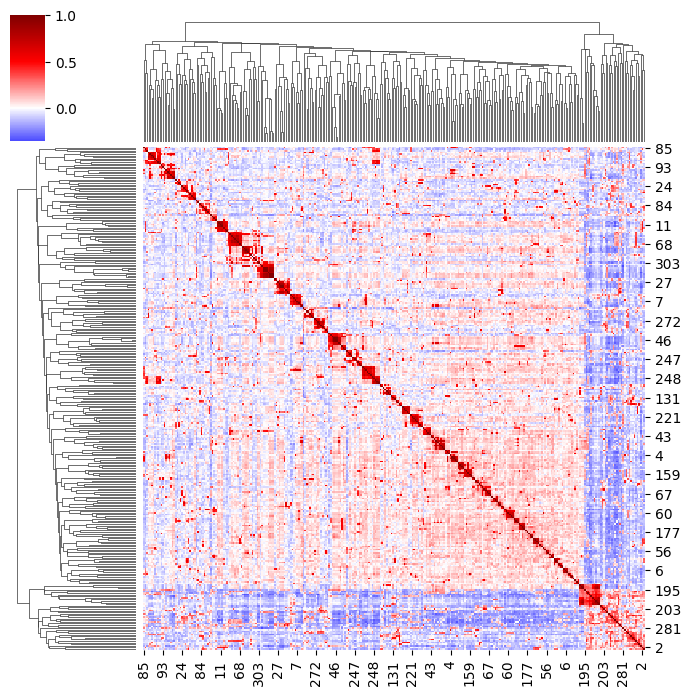

In [21]:
sns.clustermap(psa_est_mrna_gc1['R'], cmap='seismic', figsize=(7, 7), center=0)

In [22]:
psa_mrna_gc1_link = linkage(y=psa_est_mrna_gc1['R'], method="average", metric="euclidean")

In [23]:
psa_ggl_gc1 = gg_lasso_network_analysis(N=psa_mrna_gc1.shape[0], estimate=psa_est_mrna_gc1)
psa_ggl_gc1.create_problem(S_col="R", latent=False)
psa_ggl_gc1.model_selection(lambda1_range=np.logspace(0, -6, 100), gamma=0.1)

 
SINGLE GRAPHICAL LASSO PROBLEM 
Regularization parameters:
{'lambda1': 0.05, 'mu1': None}
ADMM terminated after 11 iterations with status: optimal.
ADMM terminated after 10 iterations with status: optimal.
ADMM terminated after 10 iterations with status: optimal.
ADMM terminated after 23 iterations with status: optimal.
ADMM terminated after 11 iterations with status: optimal.
ADMM terminated after 11 iterations with status: optimal.
ADMM terminated after 12 iterations with status: optimal.
ADMM terminated after 10 iterations with status: optimal.
ADMM terminated after 11 iterations with status: optimal.
ADMM terminated after 23 iterations with status: optimal.
ADMM terminated after 23 iterations with status: optimal.
ADMM terminated after 12 iterations with status: optimal.
ADMM terminated after 12 iterations with status: optimal.
ADMM terminated after 12 iterations with status: optimal.
ADMM terminated after 24 iterations with status: optimal.
ADMM terminated after 25 iterations wi

In [24]:
psa_sol_gc1 = psa_ggl_gc1.P.solution.precision_

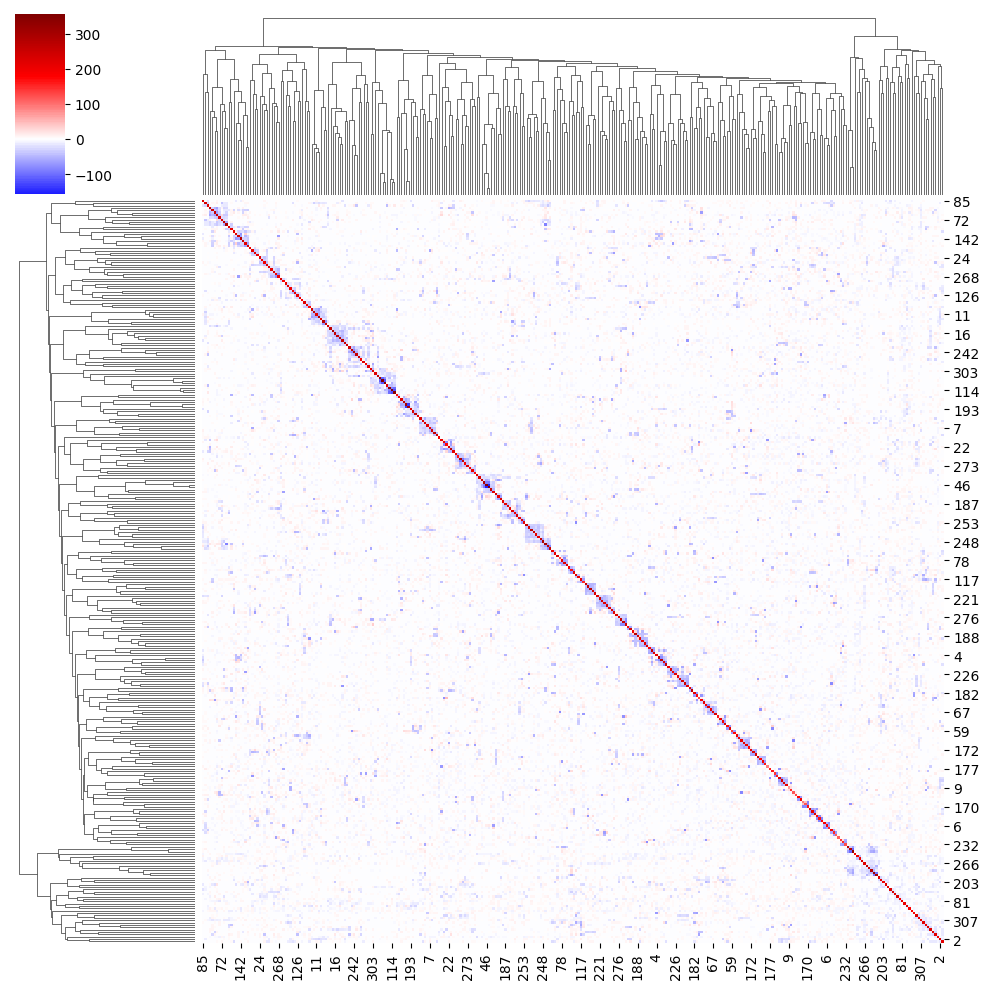

In [25]:
sns.clustermap(psa_sol_gc1, cmap="seismic", col_linkage=psa_mrna_gc1_link, row_linkage=psa_mrna_gc1_link, figsize=(10, 10), center=0)

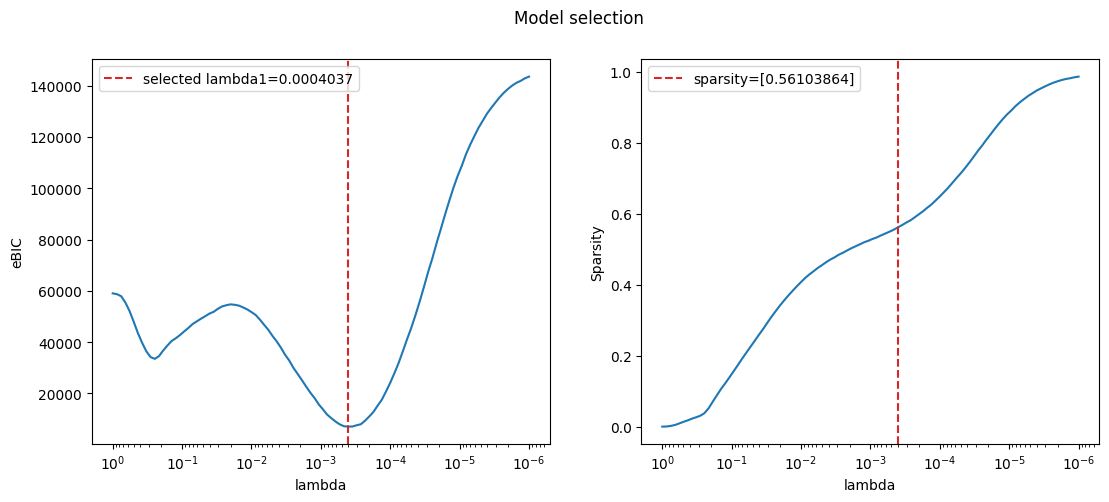

In [26]:
P_dict = psa_ggl_gc1.P.__dict__

lambda1 = P_dict["reg_params"]["lambda1"]
lambda1_range = P_dict["modelselect_params"]["lambda1_range"]
sparsity = P_dict["modelselect_stats"]["SP"]
eBIC = P_dict["modelselect_stats"]["BIC"][0.1]

fig, axs = plt.subplots(1, 2, figsize=(13, 5))

sns.lineplot(x=lambda1_range, y=eBIC.squeeze(), ax=axs[0])
axs[0].axvline(x=lambda1, ls="--", color="C3", label=f"selected lambda1={np.round(lambda1, 7)}")
axs[0].set_xscale("log")
axs[0].set_xlabel("lambda")
axs[0].set_ylabel("eBIC")
axs[0].invert_xaxis()
axs[0].legend()

sns.lineplot(x=lambda1_range, y=sparsity.squeeze(), ax=axs[1])
axs[1].axvline(x=lambda1, ls="--", color="C3", label=f"sparsity={sparsity[np.where(lambda1_range == lambda1)[0][0]]}")
axs[1].set_xscale("log")
axs[1].set_xlabel("lambda")
axs[1].set_ylabel("Sparsity")
axs[1].invert_xaxis()
axs[1].legend()
plt.suptitle("Model selection")
plt.show()

In [27]:
#number of nodes
print("nodes:", psa_sol_gc1.shape[0])
#number of edges
print(np.count_nonzero(np.triu(psa_sol_gc1, k=1)))
#ebic value
print(eBIC[np.where(lambda1_range == lambda1)[0][0]])

nodes: 314
27570
[7063.72904052]


### GC1: EMP COV + GGL

In [29]:
psa_gc1_emp_cov_est = np.cov(psa_mrna_gc1.layers['sqrt_counts'].A.T, bias=True)

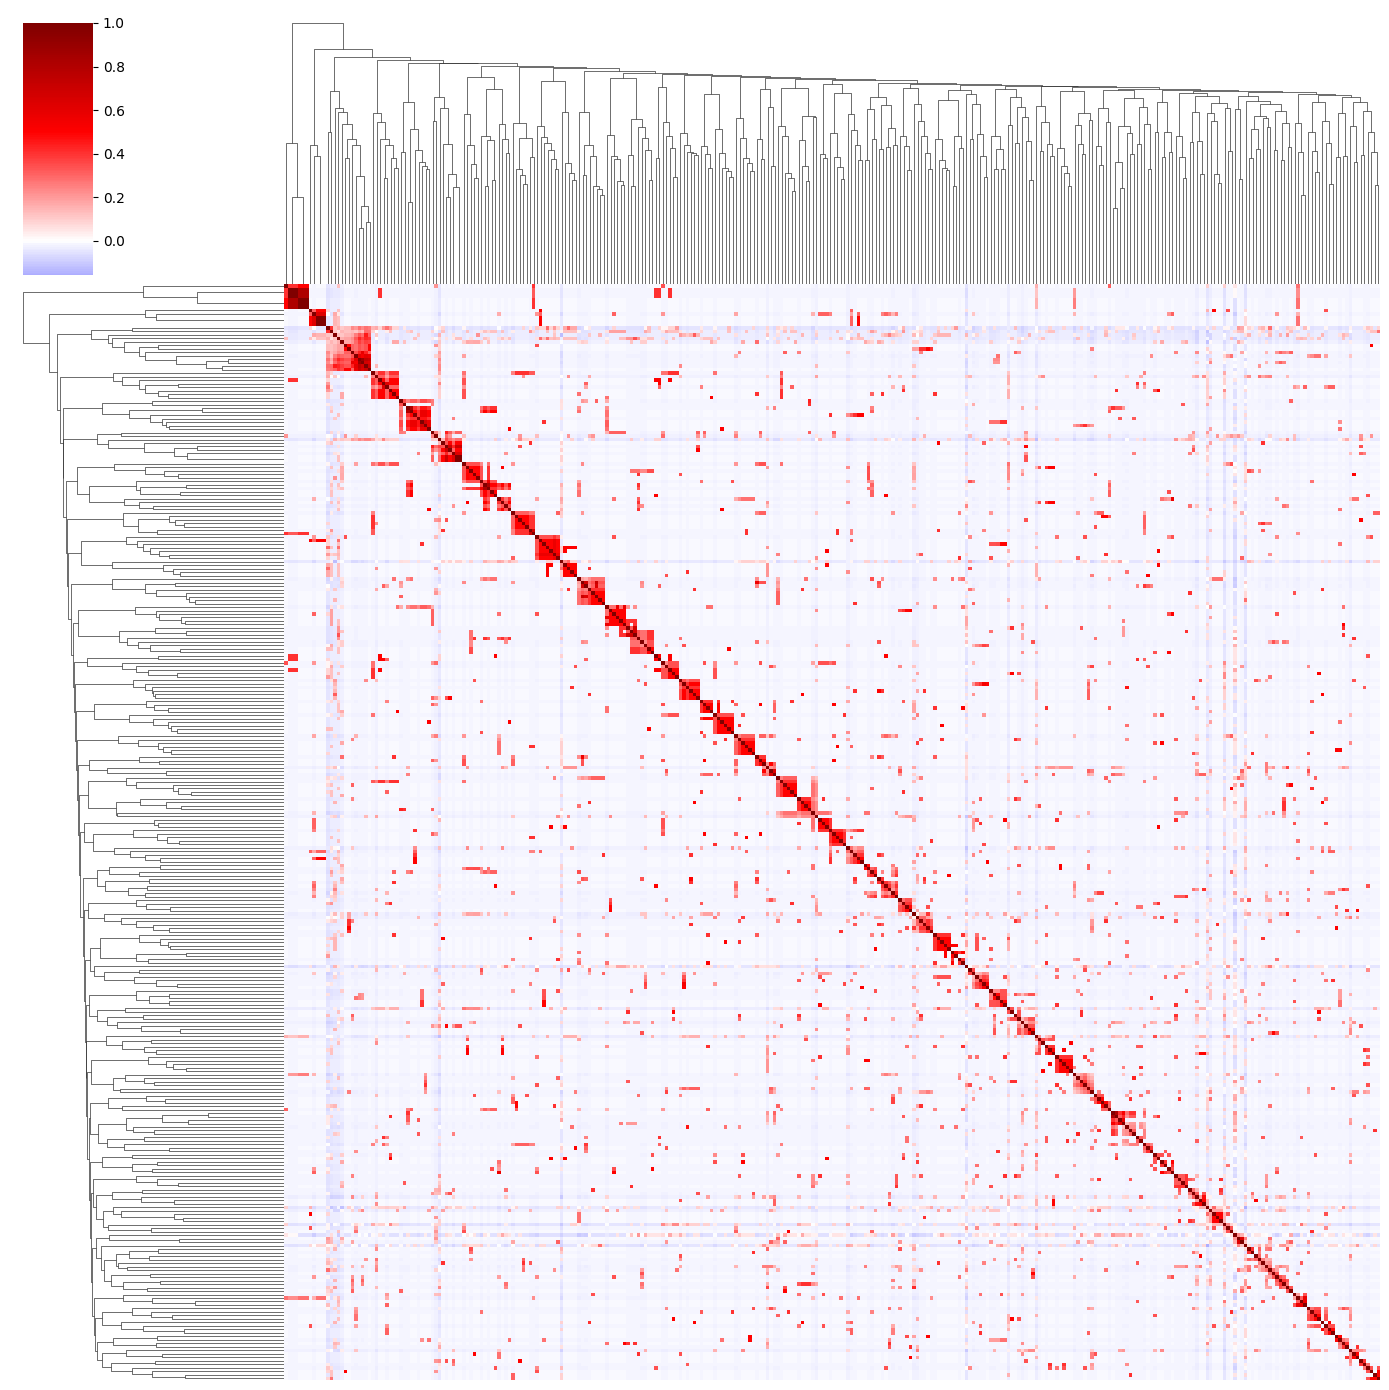

In [30]:
cm = sns.clustermap(scale_array_by_diagonal(psa_gc1_emp_cov_est), cmap='seismic', center=0, figsize=(14, 14), xticklabels=False, yticklabels=False)

In [31]:
link = linkage(y=scale_array_by_diagonal(psa_gc1_emp_cov_est), method="average", metric="euclidean")

In [32]:
print(psa_gc1_emp_cov_est.min(), psa_gc1_emp_cov_est.max())
print(scale_array_by_diagonal(psa_gc1_emp_cov_est).min(), scale_array_by_diagonal(psa_gc1_emp_cov_est).max())

-0.02497124750544276 0.20517420284833152
-0.15684180239699344 1.0000000000000002


In [33]:
psa_ggl_cov_gc1 = gg_lasso_network_analysis(N=psa_mrna_gc1.shape[0], estimate=scale_array_by_diagonal(psa_gc1_emp_cov_est))
psa_ggl_cov_gc1.create_problem(latent=False)
psa_ggl_cov_gc1.model_selection(lambda1_range=np.logspace(0, -6, 100), gamma=0.1)

 
SINGLE GRAPHICAL LASSO PROBLEM 
Regularization parameters:
{'lambda1': 0.05, 'mu1': None}
ADMM terminated after 10 iterations with status: optimal.
ADMM terminated after 10 iterations with status: optimal.
ADMM terminated after 10 iterations with status: optimal.
ADMM terminated after 10 iterations with status: optimal.
ADMM terminated after 12 iterations with status: optimal.
ADMM terminated after 9 iterations with status: optimal.
ADMM terminated after 13 iterations with status: optimal.
ADMM terminated after 10 iterations with status: optimal.
ADMM terminated after 11 iterations with status: optimal.
ADMM terminated after 10 iterations with status: optimal.
ADMM terminated after 11 iterations with status: optimal.
ADMM terminated after 11 iterations with status: optimal.
ADMM terminated after 27 iterations with status: optimal.
ADMM terminated after 12 iterations with status: optimal.
ADMM terminated after 11 iterations with status: optimal.
ADMM terminated after 26 iterations wit

In [34]:
psa_sol_cov_gc1 = psa_ggl_cov_gc1.P.solution.precision_

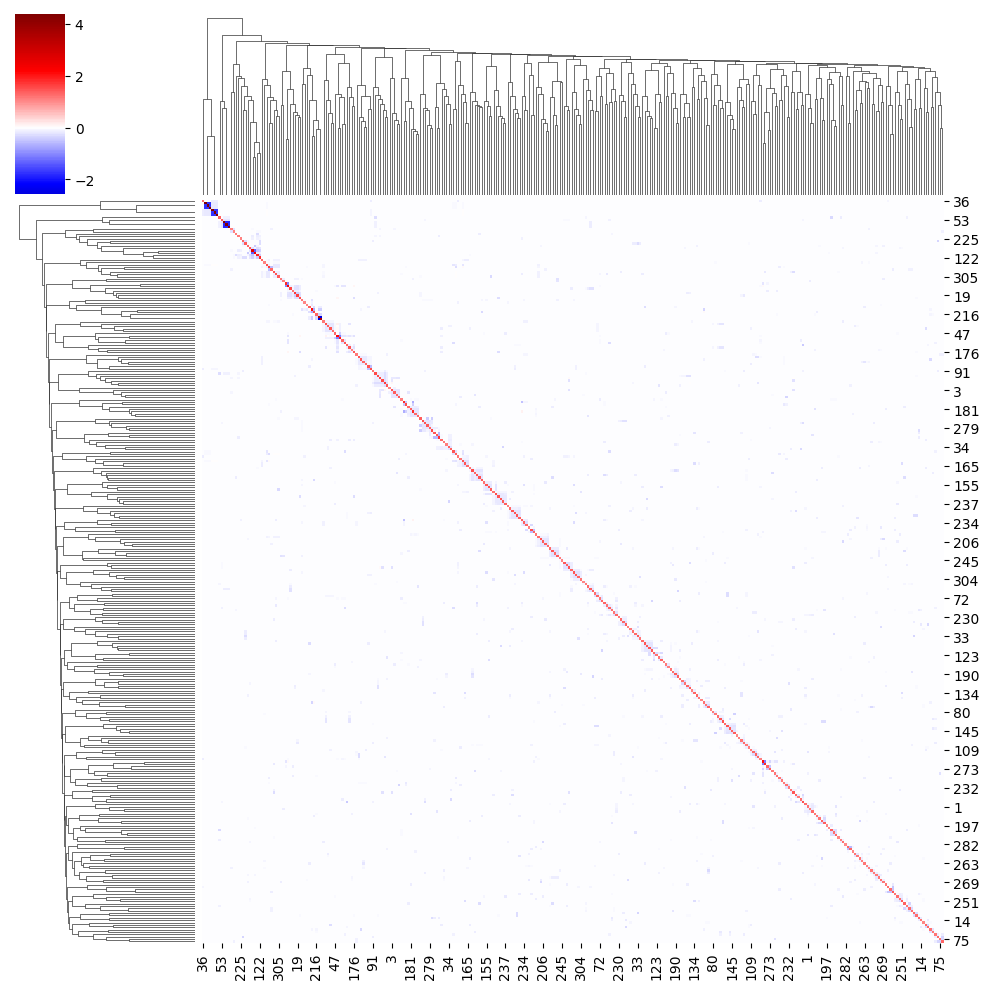

In [35]:
sns.clustermap(psa_sol_cov_gc1, cmap="seismic", col_linkage=link, row_linkage=link, figsize=(10, 10), center=0)

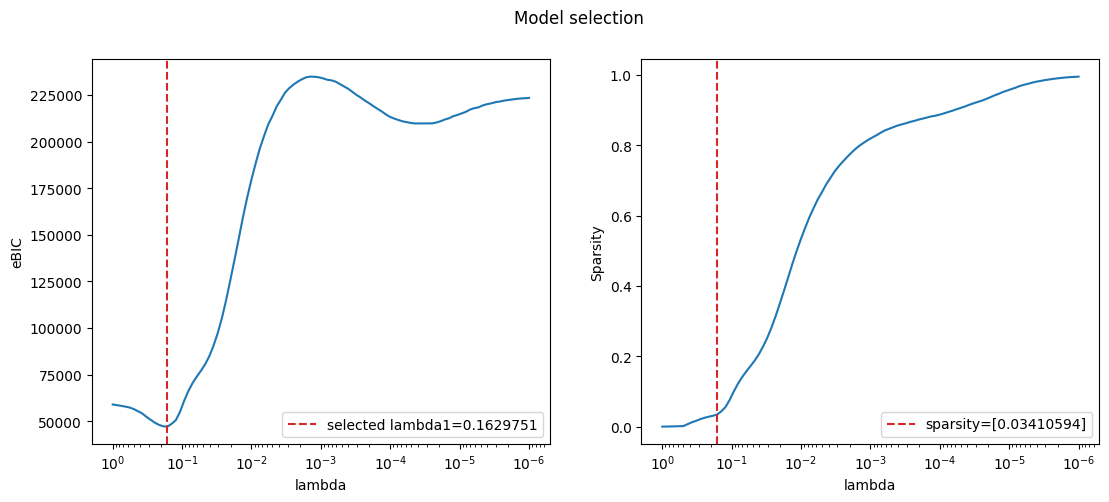

In [36]:
P_dict = psa_ggl_cov_gc1.P.__dict__

lambda1 = P_dict["reg_params"]["lambda1"]
lambda1_range = P_dict["modelselect_params"]["lambda1_range"]
sparsity = P_dict["modelselect_stats"]["SP"]
eBIC = P_dict["modelselect_stats"]["BIC"][0.1]

fig, axs = plt.subplots(1, 2, figsize=(13, 5))

sns.lineplot(x=lambda1_range, y=eBIC.squeeze(), ax=axs[0])
axs[0].axvline(x=lambda1, ls="--", color="C3", label=f"selected lambda1={np.round(lambda1, 7)}")
axs[0].set_xscale("log")
axs[0].set_xlabel("lambda")
axs[0].set_ylabel("eBIC")
axs[0].invert_xaxis()
axs[0].legend()

sns.lineplot(x=lambda1_range, y=sparsity.squeeze(), ax=axs[1])
axs[1].axvline(x=lambda1, ls="--", color="C3", label=f"sparsity={sparsity[np.where(lambda1_range == lambda1)[0][0]]}")
axs[1].set_xscale("log")
axs[1].set_xlabel("lambda")
axs[1].set_ylabel("Sparsity")
axs[1].invert_xaxis()
axs[1].legend()
plt.suptitle("Model selection")
plt.show()

In [37]:
#number of nodes
print("nodes:", psa_sol_cov_gc1.shape[0])
#number of edges
print("edges:", np.count_nonzero(np.triu(psa_sol_cov_gc1, k=1)))
#ebic value
print("eBIC value: ", eBIC[np.where(lambda1_range == lambda1)[0][0]])

nodes: 314
edges: 1676
eBIC value:  [47165.60584792]


In [30]:
labels = efm_mrna_gc1.var["protein_name"].values
labels = [label.split("[")[0] for label in labels]
labels[1]

'WP_001015311.1 MULTISPECIES: IS6-like element IS1216 family transposase '

In [37]:
labels_prot = [label.split(" ")[0] for label in efm_mrna_gc1.var["protein_name"].values]
labels_prot[1]

'WP_001015311.1'

In [45]:
new_indices = cm.dendrogram_row.reordered_ind
efm_sol_gc1_reorder = efm_sol_gc1[new_indices, :]
efm_sol_gc1_reorder = efm_sol_gc1_reorder[:, new_indices]

labels_prot_reorder = [labels_prot[i] for i in new_indices]

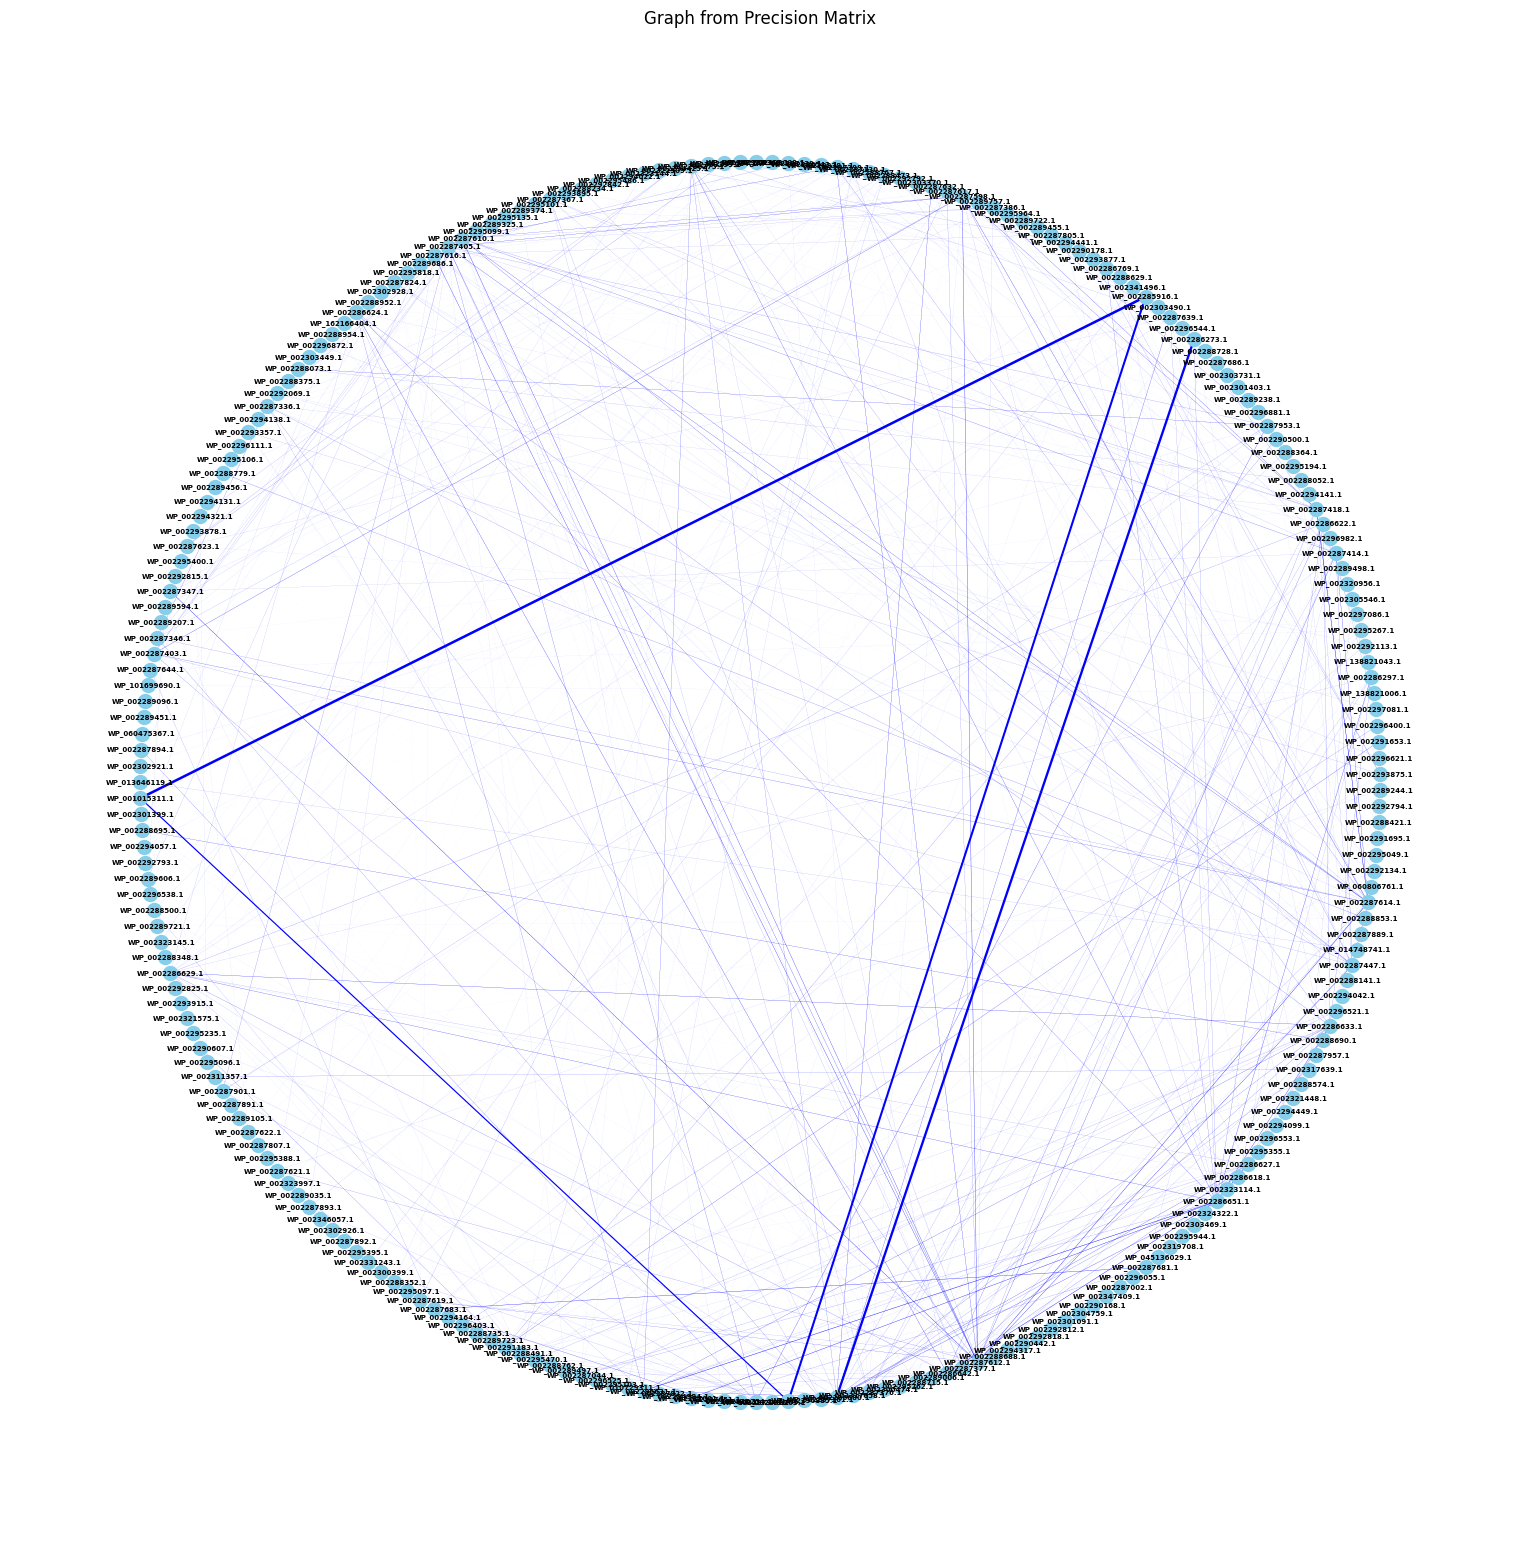

In [47]:
ec_G = nx.Graph()

# Add nodes to the graph
for row in labels_prot_reorder:
    ec_G.add_node(row)

# Add edges to the graph based on the weights
n = efm_sol_gc1.shape[0]
for i in range(n):
    for j in range(i + 1, n):
        weight = efm_sol_gc1_reorder[i, j]
        if weight != 0:
            ec_G.add_edge(labels_prot[i], labels_prot[j], weight=weight)

# Set edge colors based on weight sign
edge_colors = []
edge_widths = []
for edge in ec_G.edges(data=True):
    weight = edge[2]['weight']
    if weight > 0:
        edge_colors.append('red')  # Positive edge
    elif weight < 0:
        edge_colors.append('blue')  # Negative edge
    edge_widths.append(abs(weight)*2)  # Scale width based on weight


# Draw the graph
pos = nx.shell_layout(ec_G)
plt.figure(figsize=(15, 15))
nx.draw(ec_G, pos, with_labels=True, node_size=100, node_color='skyblue', font_size=5, font_weight='bold', 
        edge_color=edge_colors, width=edge_widths)
plt.title('Graph from Precision Matrix')
plt.show()

In [61]:
for i in labels:
    if i == "None": continue
    if "MULTISPECIES:" in i:
        print(" ".join(i.split(" ")[2:]))
    else:
        print(" ".join(i.split(" ")[1:]))

IS6-like element IS1216 family transposase 
leucine--tRNA ligase 
polysaccharide biosynthesis protein 
accessory gene regulator B family protein 
sensor histidine kinase 
glucosaminidase domain-containing protein 
glucose-6-phosphate dehydrogenase 
DivIVA domain-containing protein 
RNA-binding protein 
cell division protein SepF 
cell division protein FtsZ 
cell division protein FtsA 
cell division protein FtsQ/DivIB 
16S rRNA (cytosine(1402)-N(4))-methyltransferase RsmH 
DNA repair protein RecN 
GRP family sugar transporter 
type I glutamate--ammonia ligase 
MerR family transcriptional regulator 
phosphopantothenate--cysteine ligase 
ribonuclease J 
zinc metallopeptidase 
TIGR01906 family membrane protein 
ribonuclease Y 
bifunctional UDP-N-acetylglucosamine diphosphorylase/glucosamine-1-phosphate N-acetyltransferase GlmU 
ribose-phosphate diphosphokinase 
primosomal protein N' 
Stp1/IreP family PP2C-type Ser/Thr phosphatase 
Stk1 family PASTA domain-containing Ser/Thr kinase 
NlpC/P6

In [62]:
mapping = pd.read_csv("../data/string/efm/string_mapping_efm.tsv", sep="\t")
mapping

,#queryIndex,queryItem,stringId,preferredName,annotation
0,2,leucine--tRNA ligase,1352.AL014_13845,leuS_1,leucyl-tRNA synthetase; Derived by automated c...
1,3,polysaccharide biosynthesis protein,1352.AL014_02810,AOM15246.1,Polysaccharide biosynthesis protein; Derived b...
2,5,sensor histidine kinase,1352.AL014_03180,phoR_2,Histidine kinase; Derived by automated computa...
3,7,glucose-6-phosphate dehydrogenase,1352.AL014_08335,zwf,Glucose-6-phosphate dehydrogenase; Catalyzes t...
4,8,DivIVA domain-containing protein,1352.AL014_08345,DivIVA,Cell division protein DivIVA; Derived by autom...
...,...,...,...,...,...
158,237,glycine--tRNA ligase subunit beta,1352.AL014_02680,glyS_1,glycine-tRNA synthetase subunit beta; Derived ...
159,238,phospho-sugar mutase,1352.AL014_02595,Pgm2,Phosphoglucomutase; Catalyzes the interconvers...
160,240,DNA topoisomerase IV subunit B,1352.AL014_04900,gyrB,DNA gyrase subunit B; Topoisomerase IV is esse...
161,241,rod shape-determining protein MreC,1352.AL014_13475,mreC,Rod shape-determining protein MreC; Involved i...


In [63]:
for i, row in mapping.iterrows():
    query = row["queryItem"]
    target_index = efm_mrna_gc1.var.loc[efm_mrna_gc1.var["protein_name"].str.contains(query)].index
    for i in target_index:
        efm_mrna_gc1.var.loc[i, "string_id"] = row["stringId"]

C:\Users\Jan\AppData\Local\Temp\ipykernel_4948\2353193877.py:3: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  target_index = efm_mrna_gc1.var.loc[efm_mrna_gc1.var["protein_name"].str.contains(query)].index


In [64]:
efm_mrna_gc1.var

,strains,matchin_protein,protein,n_cells_by_counts,mean_counts,pct_dropout_by_counts,total_counts,n_cells,protein_name,rRNA,...,PC_lev1,PC_lev2,PC_lev3,PC_lev4,PC_lev5,PC_lev6,log1p_mean_counts,log1p_total_counts,n_counts,string_id
cds-FCF09_RS09120,GSM5456504_Efm_CDS,no_match,no_match,74,0.015718,98.428207,74.0,135,None,False,...,no_match,no_match,no_match,no_match,no_match,no_match,0.015596,4.317488,74.0,nan
cds-WP_001015311.1,GSM5456506_Kp_CDS,match,WP_001015311.1,86,0.018692,98.173322,88.0,119,WP_001015311.1 MULTISPECIES: IS6-like element ...,False,...,forDFlev1219,forDFlev2219,forDFlev3219,forDFlev4219,forDFlev5219,forDFlev6219,0.018519,4.488636,88.0,nan
cds-WP_002285916.1,GSM5456506_Kp_CDS,match,WP_002285916.1,151,0.034410,96.792693,162.0,236,WP_002285916.1 MULTISPECIES: leucine--tRNA lig...,False,...,forDFlev11003,forDFlev21003,forDFlev31003,forDFlev41003,forDFlev51003,forDFlev61003,0.033831,5.093750,162.0,1352.AL014_13845
cds-WP_002286080.1,GSM5456506_Kp_CDS,match,WP_002286080.1,63,0.014019,98.661852,66.0,118,WP_002286080.1 MULTISPECIES: polysaccharide bi...,False,...,forDFlev1213,forDFlev2213,forDFlev3213,forDFlev4213,forDFlev5213,forDFlev6213,0.013921,4.204693,66.0,1352.AL014_02810
cds-WP_002286273.1,GSM5456506_Kp_CDS,match,WP_002286273.1,63,0.013381,98.661852,63.0,97,WP_002286273.1 MULTISPECIES: accessory gene re...,False,...,forDFlev12779,forDFlev22779,forDFlev32779,forDFlev42779,forDFlev52779,forDFlev62779,0.013293,4.158883,63.0,nan
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
cds-WP_060806761.1,GSM5456506_Kp_CDS,match,WP_060806761.1,82,0.017842,98.258284,84.0,128,WP_060806761.1 MULTISPECIES: phospho-sugar mut...,False,...,forDFlev12697,forDFlev22697,forDFlev32697,forDFlev42697,forDFlev52697,forDFlev62697,0.017685,4.442651,84.0,1352.AL014_02595
cds-WP_101699690.1,GSM5456506_Kp_CDS,match,WP_101699690.1,73,0.016355,98.449448,77.0,112,WP_101699690.1 M13-type metalloendopeptidase [...,False,...,forDFlev15363,forDFlev25363,forDFlev35363,forDFlev45363,forDFlev55363,forDFlev65363,0.016223,4.356709,77.0,nan
cds-WP_138821006.1,GSM5456506_Kp_CDS,match,WP_138821006.1,68,0.014656,98.555650,69.0,117,WP_138821006.1 DNA topoisomerase IV subunit B ...,False,...,forDFlev1921,forDFlev2921,forDFlev3921,forDFlev4921,forDFlev5921,forDFlev6921,0.014550,4.248495,69.0,1352.AL014_04900
cds-WP_138821043.1,GSM5456506_Kp_CDS,match,WP_138821043.1,63,0.013594,98.661852,64.0,101,WP_138821043.1 rod shape-determining protein M...,False,...,forDFlev11381,forDFlev21381,forDFlev31381,forDFlev41381,forDFlev51381,forDFlev61381,0.013502,4.174387,64.0,1352.AL014_13475


In [65]:
interactions = pd.read_csv("../data/string/efm/string_interactions_short_efm.tsv", sep="\t")
interactions

,#node1,node2,node1_string_id,node2_string_id,neighborhood_on_chromosome,gene_fusion,phylogenetic_cooccurrence,homology,coexpression,experimentally_determined_interaction,database_annotated,automated_textmining,combined_score
0,AOM14739.1,stp_3,1352.AL014_00005,1352.AL014_13450,0.000,0.0,0.154,0.0,0.324,0.000,0.000,0.000,0.403
1,AOM14739.1,groEL,1352.AL014_00005,1352.AL014_14690,0.000,0.0,0.323,0.0,0.000,0.000,0.000,0.159,0.406
2,AOM14739.1,smc,1352.AL014_00005,1352.AL014_11670,0.093,0.0,0.000,0.0,0.148,0.237,0.000,0.192,0.459
3,AOM14739.1,sepF_1,1352.AL014_00005,1352.AL014_08360,0.000,0.0,0.000,0.0,0.401,0.000,0.000,0.165,0.478
4,AOM14739.1,ftsA_1,1352.AL014_00005,1352.AL014_08375,0.072,0.0,0.000,0.0,0.378,0.000,0.000,0.191,0.492
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1019,thrS_4,tuf,1352.AL014_04055,1352.AL014_04595,0.046,0.0,0.000,0.0,0.142,0.381,0.074,0.194,0.552
1020,tig,tuf,1352.AL014_07220,1352.AL014_04595,0.093,0.0,0.000,0.0,0.480,0.000,0.000,0.194,0.586
1021,tig,typA_1,1352.AL014_07220,1352.AL014_05325,0.069,0.0,0.000,0.0,0.442,0.000,0.000,0.267,0.585
1022,tpiA,zwf,1352.AL014_02215,1352.AL014_08335,0.000,0.0,0.000,0.0,0.088,0.000,0.800,0.278,0.856


In [66]:
n = efm_mrna_gc1.shape[1]
non_zero_entries = np.count_nonzero(efm_sol_gc1)
num_reported_interactions = 0

for i in range(n):
    for j in range(i+1, n):
        if efm_sol_gc1[i, j] != 0:
            a = efm_mrna_gc1.var.iloc[i]["string_id"]
            b = efm_mrna_gc1.var.iloc[j]["string_id"]
            
            interaction = interactions.loc[(interactions["node1_string_id"] == a) & (interactions["node2_string_id"] == b)]["combined_score"]
            if len(interaction) > 0:
                for k in range(len(interaction)):
                    print(f"{efm_mrna_gc1.var.iloc[i]['protein_name']} - {efm_mrna_gc1.var.iloc[j]['protein_name']}: {interaction.values[k]}")
                    num_reported_interactions += 1

WP_002286629.1 MULTISPECIES: cell division protein FtsZ [Enterococcus] - WP_002288500.1 MULTISPECIES: transcription termination factor NusA [Enterococcus]: 0.405
WP_002286629.1 MULTISPECIES: cell division protein FtsZ [Enterococcus] - WP_002289606.1 MULTISPECIES: PBP1A family penicillin-binding protein [Enterococcus]: 0.411
WP_002286629.1 MULTISPECIES: cell division protein FtsZ [Enterococcus] - WP_002290442.1 MULTISPECIES: elongation factor Tu [Enterococcus]: 0.532
WP_002286629.1 MULTISPECIES: cell division protein FtsZ [Enterococcus] - WP_002290607.1 MULTISPECIES: chaperonin GroEL [Enterococcus]: 0.495
WP_002286629.1 MULTISPECIES: cell division protein FtsZ [Enterococcus] - WP_002321575.1 MULTISPECIES: DNA gyrase subunit A [Enterococcus]: 0.723
WP_002287403.1 MULTISPECIES: transcription-repair coupling factor [Enterococcus] - WP_002289722.1 MULTISPECIES: ATP-dependent DNA helicase RecG [Enterococcus]: 0.475
WP_002287612.1 MULTISPECIES: beta-ketoacyl-ACP synthase III [Enterococcus] - 

In [67]:
num_reported_interactions

13

In [68]:
non_zero_entries

1169

In [69]:
num_reported_interactions / non_zero_entries

0.011120615911035072